In [1]:
import numpy as np
import scipy.io as scio # load mat file
from scipy.signal import welch, filtfilt
from scipy.interpolate import interp1d

from PSO import *  # demo PSO codes!

import matplotlib.pyplot as plt

In [2]:
# load data
TrainingData = scio.loadmat('TrainingData.mat') # only noise    
analysisData = scio.loadmat('analysisData.mat') # noise + signal

## Preparing
dataY = analysisData['dataVec'][0] # (2048,)
# Data length
nSamples = dataY.size # 2048
# Sampling frequency
Fs = analysisData['sampFreq'][0,0] # 1024

# Search range of phase coefficients
rmin = [40, 1, 1]
rmax = [100, 50, 15]

# Noise realization: PSD estimated from TrainingData
dt = 1/Fs
t = np.arange(0, nSamples*dt, dt) # (2048,)
T = nSamples/Fs
df = 1/T
Nyq = Fs/2 # Nyquist frequency
[f, pxx] = welch(TrainingData['trainData'][0], fs=Fs, 
                 window='hamming', nperseg=Fs/2, 
                 noverlap=None, nfft=None, 
                 detrend=False) 
# Why 'detrend=False'? 
# See https://github.com/scipy/scipy/issues/8045#issuecomment-337319294
# or https://iphysresearch.github.io/blog/post/signal_processing/spectral_analysis_scipy/

# Smooth the PSD estimate
smthOrdr = 10
b = np.ones(smthOrdr)/smthOrdr
pxxSmth = filtfilt(b,1,pxx)
# PSD must be supplied at DFT frequencies.
kNyq = np.floor(nSamples/2) + 1
posFreq = np.arange(0, kNyq)*Fs/nSamples
psdPosFreq = interp1d(f,pxxSmth)(posFreq)

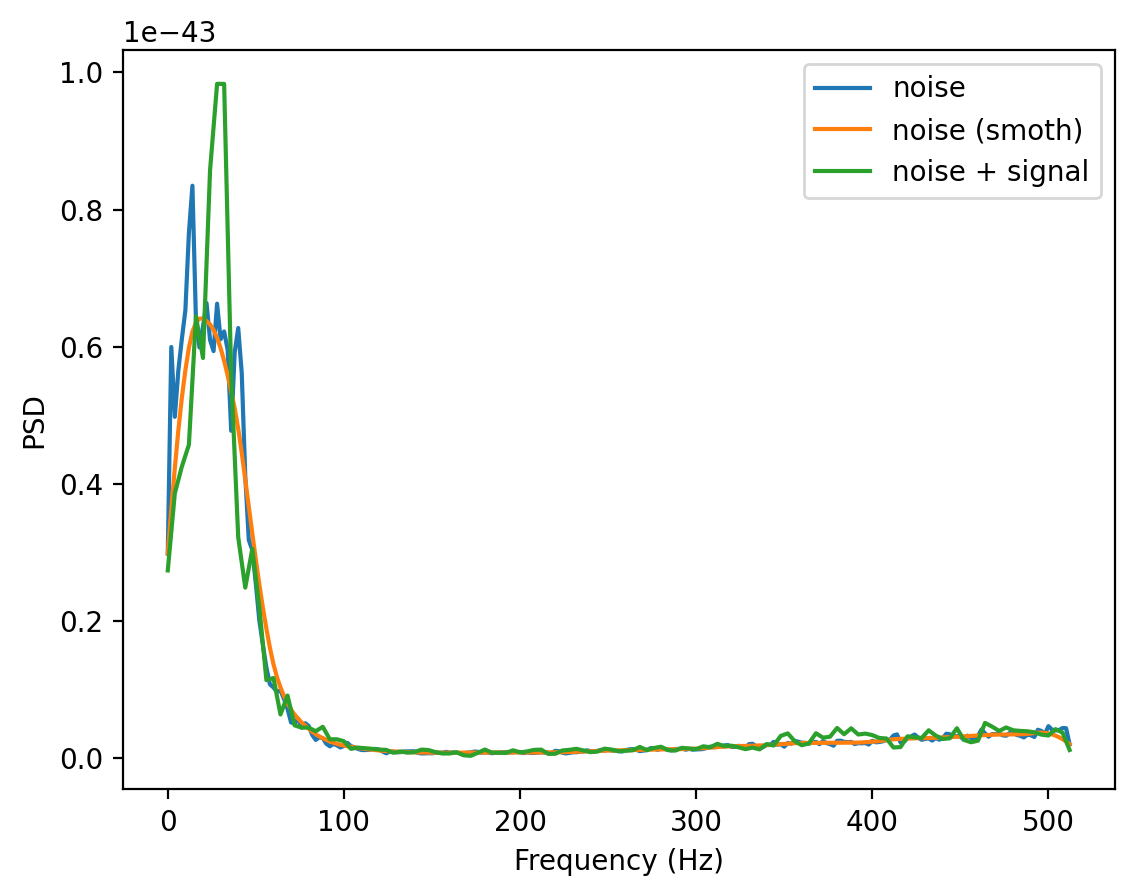

In [3]:
# Plot PSDs for the noise and noise + signal.
plt.figure(dpi=200)
plt.plot(f,pxx, label='noise')
plt.plot(f,pxxSmth, label='noise (smoth)')
[f, pxxY] = welch(dataY, fs=Fs, 
                 window='hamming', nperseg=256, 
                 noverlap=None, nfft=None, 
                 detrend=False)
plt.plot(f,pxxY, label='noise + signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.savefig('output_psd.png', dpi=200)
plt.show()

In [4]:
# Number of independent PSO runs
nRuns = 8

In [5]:
# calculate Amplitude of the signal (changed by ywq)
deita = np.std(TrainingData['trainData'][0])
dataYmax = np.max(dataY)
dataYmin = np.min(dataY)
A = (dataYmax - dataYmin) / 2
A_signal = np.sqrt(A ** 2 - deita ** 2)
print("振幅为：", A_signal)

振幅为： 5.600985972378616e-21


In [6]:
## PSO
# Input parameters for CRCBQCHRPPSO
inParams = {
    'dataX': t,
    'dataY': dataY,
    'dataXSq': t**2,
    'dataXCb': t**3,
    'psdPosFreq': psdPosFreq,
    'sampFreq': Fs,
    'rmin': rmin,
    'rmax': rmax,
    'A': A_signal,
    'noise':TrainingData['trainData'][0],
}
# CRCBQCHRPPSOPSD runs PSO on the CRCBQCHRPFITFUNC fitness function. As an
# illustration of usage, we change one of the PSO parameters from its
# default value.
outResults, outStruct = crcbqcpsopsd(inParams, {'maxSteps': 20}, nRuns)

Overall Progress:   0%|          | 0/8 [00:00<?, ?it/s]







Overall Progress:  12%|█▎        | 1/8 [00:00<00:01,  6.03it/s]



100%|██████████| 20/20 [00:00<00:00, 166.75it/s]

100%|██████████| 20/20 [00:00<00:00, 160.23it/s]








100%|██████████| 20/20 [00:00<00:00, 151.59it/s]















100%|██████████| 20/20 [00:00<00:00, 167.46it/s]




100%|██████████| 20/20 [00:00<00:00, 170.48it/s]:00, 18.22it/s]






100%|██████████| 20/20 [00:00<00:00, 169.83it/s]







100%|██████████| 20/20 [00:00<00:00, 143.99it/s]





Overall Progress: 100%|██████████| 8/8 [00:00<00:00, 22.89it/s]

-inf
算法过程中snr: -inf
inf
算法过程中snr: inf
-inf
算法过程中snr: -inf
-inf
算法过程中snr: -inf
inf
算法过程中snr: inf
inf
算法过程中snr: inf
-inf
算法过程中snr: -inf
-inf
算法过程中snr: -inf



/home/ywq/PSO_change/PSO_change/PSO_python_demo-main/PSO.py:369: RuntimeWarning: divide by zero encountered in scalar divide
  estSNR = (np.mean(llrData) - np.mean(llrNoise)) / np.std(llrNoise)
/home/ywq/PSO_change/PSO_change/PSO_python_demo-main/PSO.py:337: RuntimeWarning: invalid value encountered in multiply
  normSigVec = normFac * sigVec


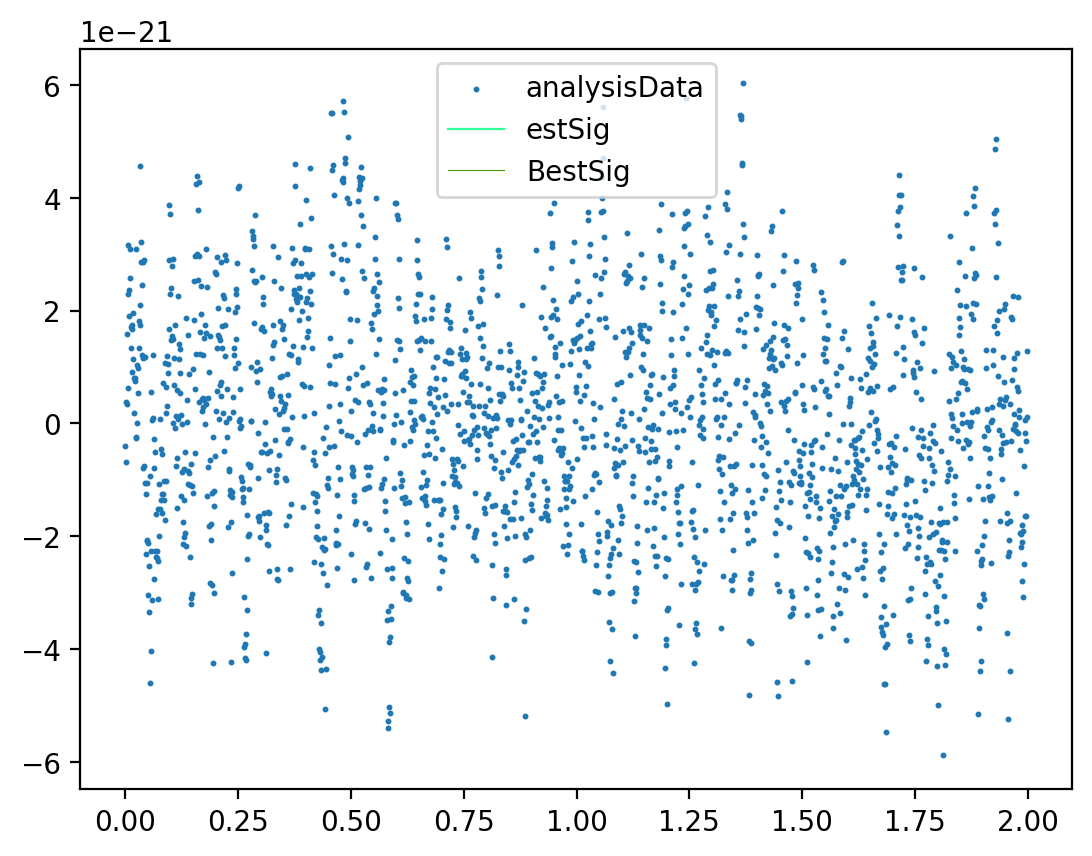

[nan nan nan ... nan nan nan]


In [7]:
## Plots
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
a=ax.scatter(t, dataY, marker='.', s=5, #label='analysisData'
             )
a.set_label('analysisData')
for lpruns in range(nRuns):
    b,=ax.plot(t, outResults['allRunsOutput'][lpruns]['estSig'],
             color=[51/255,255/255,153/255], lw=.4*2)
b.set_label('estSig')
c,=ax.plot(t, outResults['bestSig'], #label='BestSig',
         color=[76/255,153/255,0/255],lw=.2*2)
c.set_label('BestSig')
plt.legend()
plt.savefig('output_sig.png', dpi=200)
plt.show()
print(outResults['allRunsOutput'][lpruns]['estSig'])

In [8]:
# Print estimated parameters
print('Estimated parameters: a1={}; a2={}; a3={}'.format(outResults['bestQcCoefs'][0],
                                                         outResults['bestQcCoefs'][1],
                                                         outResults['bestQcCoefs'][2]),
                                    '\nbestSNR= {:.4f}'.format(outResults['bestSNR']))
for lpruns in range(nRuns):
    print('\nRun No.{}:\nbestFitness={:.2f}'.format(lpruns+1, outStruct[lpruns]['bestFitness']))   
    print('a1={:.4f}; a2={:.4f}; a3={:.4f}'.format(outResults['allRunsOutput'][lpruns]['qcCoefs'][0],
                                       outResults['allRunsOutput'][lpruns]['qcCoefs'][1],
                                       outResults['allRunsOutput'][lpruns]['qcCoefs'][2]))
# Save
np.save('output_results',outResults)
np.save('output_struct',outStruct)

Estimated parameters: a1=73.55262935499155; a2=17.607846837284537; a3=12.103478005422875 
bestSNR= 0.0000

Run No.1:
bestFitness=-7.89
a1=80.4790; a2=9.1180; a3=14.6270

Run No.2:
bestFitness=-7.25
a1=78.2281; a2=23.7344; a3=6.0016

Run No.3:
bestFitness=-7.31
a1=74.1590; a2=19.4190; a3=10.9209

Run No.4:
bestFitness=-8.64
a1=73.5526; a2=17.6078; a3=12.1035

Run No.5:
bestFitness=-8.00
a1=41.2329; a2=42.8456; a3=4.0900

Run No.6:
bestFitness=-6.84
a1=70.5863; a2=26.6237; a3=6.5933

Run No.7:
bestFitness=-8.42
a1=48.4999; a2=32.0755; a3=8.9980

Run No.8:
bestFitness=-6.98
a1=95.7049; a2=24.8646; a3=1.9818
